In [3]:
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import roguewave as rw
import matplotlib.colors
import matplotlib.cm as cm
import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt
from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
from wavespectra.input.swan import read_swans

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP_Lee'
DATA_FILENAME = 'hurricane_lee_drifter_data_v0.pickle'
with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    drifters = pickle.load(handle)

In [13]:
from roguewave.wavespectra.estimators.mem2 import mem2
from roguewave.wavespectra.estimators.mem import mem
from numba_progress import ProgressBar
from typing import Literal

Estimators = Literal["mem", "mem2"]


# -----------------------------------------------------------------------------
#                       Boilerplate Interfaces
# -----------------------------------------------------------------------------
def estimate_directional_spectrum_from_moments(
    e: np.ndarray,
    a1: np.ndarray,
    b1: np.ndarray,
    a2: np.ndarray,
    b2: np.ndarray,
    direction: np.ndarray,
    method: Estimators = "mem2",
    **kwargs,
) -> np.ndarray:
    """
    Construct a 2D directional distribution based on the directional moments and a spectral
    reconstruction method.

    :param number_of_directions: length of the directional vector for the
    2D spectrum. Directions returned are in degrees

    :param method: Choose a method in ['mem','mem2']
        mem: maximum entrophy (in the Boltzmann sense) method
        Lygre, A., & Krogstad, H. E. (1986). Explicit expression and
        fast but tends to create narrow spectra anderroneous secondary peaks.

        mem2: use entrophy (in the Shannon sense) to maximize. Likely
        best method see- Benoit, M. (1993).

    REFERENCES:
    Benoit, M. (1993). Practical comparative performance survey of methods
        used for estimating directional wave spectra from heave-pitch-roll data.
        In Coastal Engineering 1992 (pp. 62-75).

    Lygre, A., & Krogstad, H. E. (1986). Maximum entropy estimation of the
        directional distribution in ocean wave spectra.
        Journal of Physical Oceanography, 16(12), 2052-2060.

    """
    return (
        estimate_directional_distribution(a1, b1, a2, b2, direction, method, **kwargs)
        * e[..., None]
    )


def estimate_directional_distribution(
    a1: np.ndarray,
    b1: np.ndarray,
    a2: np.ndarray,
    b2: np.ndarray,
    direction: np.ndarray,
    method: Estimators = "mem2",
    **kwargs,
) -> np.ndarray:
    """
    Construct a 2D directional distribution based on the directional moments and a spectral
    reconstruction method.

    :param number_of_directions: length of the directional vector for the
    2D spectrum. Directions returned are in degrees

    :param method: Choose a method in ['mem','mem2']
        mem: maximum entrophy (in the Boltzmann sense) method
        Lygre, A., & Krogstad, H. E. (1986). Explicit expression and
        fast but tends to create narrow spectra anderroneous secondary peaks.

        mem2: use entrophy (in the Shannon sense) to maximize. Likely
        best method see- Benoit, M. (1993).

    REFERENCES:
    Benoit, M. (1993). Practical comparative performance survey of methods
        used for estimating directional wave spectra from heave-pitch-roll data.
        In Coastal Engineering 1992 (pp. 62-75).

    Lygre, A., & Krogstad, H. E. (1986). Maximum entropy estimation of the
        directional distribution in ocean wave spectra.
        Journal of Physical Oceanography, 16(12), 2052-2060.

    """

    # Jacobian to transform distribution as function of radian angles into
    # degrees.
    Jacobian = np.pi / 180
    direction_radians = direction * Jacobian

    if method.lower() in ["maximum_entropy_method", "mem"]:
        # reconstruct the directional distribution using the maximum entropy
        # method.
        function = mem
    elif method.lower() in ["maximum_entrophy_method2", "mem2"]:
        function = mem2
    else:
        raise Exception(f"unsupported spectral estimator method: {method}")

    output_shape = list(a1.shape) + [len(direction)]
    if a1.ndim == 1:
        input_shape = [1, a1.shape[-1]]
    else:
        input_shape = [numpy.prod(a1.shape[0:-1]), a1.shape[-1]]

    a1 = a1.reshape(input_shape)
    b1 = b1.reshape(input_shape)
    a2 = a2.reshape(input_shape)
    b2 = b2.reshape(input_shape)

    number_of_iterations = a1.shape[0]
    if number_of_iterations < 10:
        disable = True
    else:
        disable = False

    if method != "mem2":
        msg = f"Reconstructing 2d spectrum with {method} using implementation: "
    else:
        solution_method = kwargs.get("solution_method", "scipy")
        msg = f"Reconstructing 2d spectrum with {method} using solution_method {solution_method}"

    with ProgressBar(total=number_of_iterations, disable=disable, desc=msg) as progress:
        res = function(direction_radians, a1, b1, a2, b2, progress, **kwargs)

    return res.reshape(output_shape) * Jacobian

In [35]:
# This is a version of Mark's specplot routine that accomodates math. convention for directions

def specpltm(Sfa, dirs=None, freqs=None, cmap=cm.Spectral_r, ax = None, cb=True, math=False):
    """Sfa = spectral density function as a function of freq and dir
    dirs = directions for Sfa data, can be omitted if Sfa contains this info (xarray)
    freqs = same as dirs but are the frequencies
    cmap = colormap used to plot the spectral intensity
    """
    if ax is None:
        ax = plt.subplot(projection='polar')
    if not math:
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi / 2.0)
    ax.set_rscale('log')
    lev1a = np.array([0.01])
    lev1b = np.arange(0.1, 0.55, 0.1)
    lev1 = np.append(lev1a, lev1b)
    if dirs is None:
        dirs = Sfa.dir
    if freqs is None:
        freqs = Sfa.freq
    cf1 = ax.contourf(np.deg2rad(dirs), freqs, Sfa, cmap=cm.Spectral_r, vmin=0.05, levels=lev1, extend='max')
    ax.set_ylim((0.05, 0.4))
    ax.set_yscale('log')
    ax.set_rticks([0.04, 0.05, 0.1, 0.2, 0.3, 0.4])
    ax.set_xticklabels(['', '45', '', '135', '', '225', '', '315'])
    ax.set_yticklabels(['', '0.05', '0.1', '0.2', '0.3', '0.4 Hz'], fontdict={'fontsize': 7})
    ax.yaxis.set_minor_formatter('')
    if cb:
        plt.colorbar(cf1)
    return cf1


In [36]:
dirs1 = np.arange(0,365,10)
df2 = drifters['spotter']['SPOT-31232C']
df2 = df2.loc[df2.a1.dropna().index]
df2a = df2[df2.index == '2023-09-16 11:45']
f = df2a.frequency[0]

# The directions are mathmatical convention...CCW from due east. 
s2d = estimate_directional_spectrum_from_moments(df2a.energy_density.values[0],
                                                     df2a.a1.values[0],
                                                     df2a.b1.values[0],
                                                     df2a.a2.values[0],
                                                     df2a.b2.values[0],
                                                     dirs1, method = 'mem')

/tmp/ipykernel_64026/416831855.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '45', '', '135', '', '225', '', '315'])


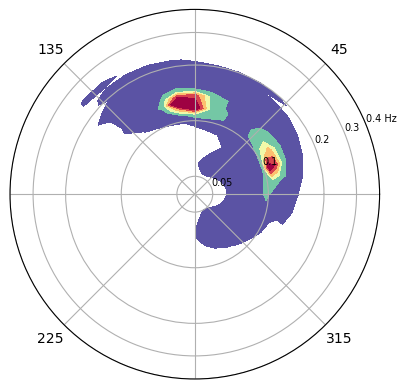

In [38]:
specpltm(s2d,dirs2,df2a.frequency[0], cb=False, math=True)
#title('SPOT 31232C', size=11)

/tmp/ipykernel_64026/416831855.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '45', '', '135', '', '225', '', '315'])


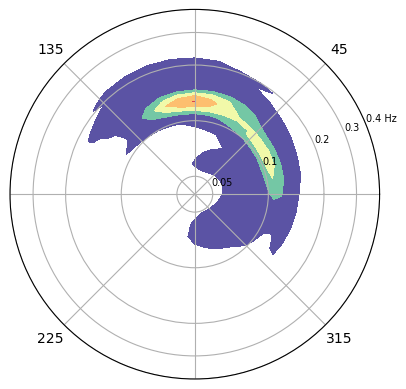

In [40]:
dirs1 = np.arange(0,365,10)
f = df2a.frequency[0]
df2 = drifters['spotter']['SPOT-31232C']
df2 = df2.loc[df2.a1.dropna().index]
df2a = df2[df2.index == '2023-09-16 11:45']

s2dm2 = estimate_directional_spectrum_from_moments(df2a.energy_density.values[0],
                                                     df2a.a1.values[0],
                                                     df2a.b1.values[0],
                                                     df2a.a2.values[0],
                                                     df2a.b2.values[0],
                                                     dirs1, method = 'mem2')
specpltm(s2dm2,dirs2,df2a.frequency[0], cb=False, math=True)
#title('SPOT 31232C', size=11)